<a href="https://colab.research.google.com/github/philshiu/Neurotransmitter-classification/blob/main/Neurotransmitter_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Neurons use different neurotransmitters to communicate; some are excitatory, while others are inhibitory; others alter neural activities in more subtle ways.
Previous efforts have used machine learning to predict what neurotransmitters a neuron uses based on electron microscopy images (Eckstein et al., 2020).
First, I reproduce those results in this project.
These previous results are from an electron microscopy volume, the "Full Adult Female Brain," (FAFB; Zhang et al., 2018), which uses serial section transmission electron microscopy.
More recent electron microscopy volumes use Focused Ion Beam Scanning Electron Microscopy, which generates superior resolution in the z dimension, at the cost of x-y resolution.
I find that using FIB-SEM microscopy images results in significantly worse neurotransmitter predictions.
Finally, I compare synapse-level neurotransmitter predictions versus synaptic bouton-level predictions. Synaptic boutons contain many synapses; Eckstein et al., 2020 predicted
neurotransmitters at the synapse-level. However, this may be problematic because each synapse level image, in which the synapse is at the center of the image. Because the synapse
is at the edge of the neuron, by definition, these images only contain 50% of the neuron of interest, and these images may be too small to contain relevant information to predict
neurotransmitters accurately. I find that predicting neurotransmitters using the entire synaptic bouton dramatically increases accuracy, even when the same total area of image data
is used for training.
'''

In [ ]:
# Import libraries
import os
import time
import tqdm
import torch
import IPython
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler


In [ ]:
#Set up using the GPU if possible
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Can we generate a classifier that accurately predicts the neurotransmitter identity of the serial section transmission electron microscopy data (Zheng et. al., 2018)?

In [ ]:
#Set up the dataloaders, and random rotation data augmentation.
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.RandomRotation(degrees = (0, 180)),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])))

val_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])))

train_data = ImageFolder(root='/content/drive/MyDrive/Pytorch test/Small FAFB 2021_08_14/Train', transform = train_transform)
val_data = ImageFolder(root='/content/drive/MyDrive/Pytorch test/Small FAFB 2021_08_14/Test', transform = val_transform)

dataloader = DataLoader(train_data, batch_size=16) 
validation_dataloader = DataLoader(val_data, batch_size=32) 

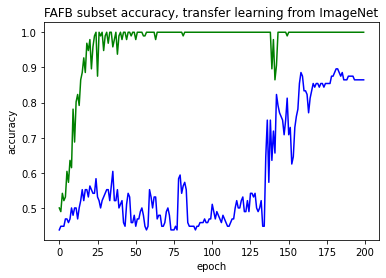

100%|██████████| 200/200 [07:20<00:00,  2.20s/it]


In [ ]:
#Train and save a resnet 18 model
save_file_prefix = '/content/drive/MyDrive/Pytorch test/2021_08_14_FAFB' 

model_to_test = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_to_test.fc.in_features
# reset final fully connected layer, number of classes = 6, for each neurotransmitter
num_classes = 2
model_to_test.fc = nn.Linear(num_ftrs, num_classes)
model_to_test.to(DEVICE)
optimizer = torch.optim.Adam(model_to_test.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

pretrained_accs = []
training_accuracy = []
for epoch in tqdm.tqdm(range(200)):
  # Train loop
  for batch in dataloader:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = model_to_test(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()
    

  # Eval loop
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = 0
    for batch in validation_dataloader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = model_to_test(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total += len(predictions)
      total_correct += num_correct
      
    pretrained_accs.append(total_correct / total)
  #Calculate the training accuracy, too
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = 0
    for batch in dataloader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = model_to_test(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total += len(predictions)
      total_correct += num_correct
      
    training_accuracy.append(total_correct / total)
    # Plot accuracy
    plt.plot(pretrained_accs, 'b')
    plt.plot(training_accuracy, 'g')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('FAFB subset accuracy, transfer learning from ImageNet')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
    #Save while this runs
    if epoch % 100 == 0 or epoch ==1:
      save_file_path = save_file_prefix + str(epoch)
      torch.save(model_to_test, save_file_path)
  plt.close()

Can we get similiar performance using data from the focused-ion beam scanning electron microscopy volume (Scheffer et al., 2020)?

In [ ]:
#First make the validation_transform dataloader
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.RandomRotation(degrees = (0, 180)),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])))

val_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])))

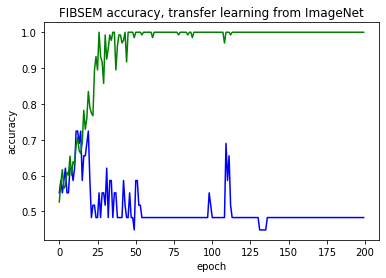

100%|██████████| 200/200 [09:12<00:00,  2.76s/it]


In [ ]:
#Train and save a resnet 18 on the FIB-SEM data
save_file_prefix = '/content/drive/MyDrive/Pytorch test/2021_08_14_FIB_SEM' # Change this to something in your google drive so it saves

model_to_test = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_to_test.fc.in_features
# reset final fully connected layer, number of classes = 6, for each neurotransmitter
num_classes = 2
model_to_test.fc = nn.Linear(num_ftrs, num_classes)
model_to_test.to(DEVICE)
optimizer = torch.optim.Adam(model_to_test.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

pretrained_accs = []
training_accuracy = []
for epoch in tqdm.tqdm(range(200)):
  # Train loop
  for batch in dataloader:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = model_to_test(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()
    

  # Eval loop
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = 0
    for batch in validation_dataloader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = model_to_test(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total += len(predictions)
      total_correct += num_correct
      
    pretrained_accs.append(total_correct / total)
  #Calculate the training accuracy, too
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = 0
    for batch in dataloader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = model_to_test(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total += len(predictions)
      total_correct += num_correct
      
    training_accuracy.append(total_correct / total)
    # Plot accuracy
    plt.plot(pretrained_accs, 'b')
    plt.plot(training_accuracy, 'g')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('FIBSEM accuracy, transfer learning from ImageNet')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
    #Save while this runs
    if epoch % 10 == 0 or epoch ==1:
      save_file_path = save_file_prefix + str(epoch)
      torch.save(model_to_test, save_file_path)
  plt.close()

If we instead use entire synaptic boutons, do we get superior accuracy?

In [ ]:
#First make the validation_transform dataloader
train_transform = transforms.Compose((#transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.CenterCrop(1000),
                                      transforms.RandomRotation(degrees = (0, 180)),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])))

val_transform = transforms.Compose((#transforms.Resize((256, 256)),
                                      transforms.ToTensor(),
                                      transforms.CenterCrop(1000),
                                      #transforms.RandomRotation(degrees = (0, 180)),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])))

In [ ]:
train_data = ImageFolder(root='/content/drive/MyDrive/Pytorch test/FAFB Synaptic boutons data/Train', transform = train_transform)
val_data = ImageFolder(root='/content/drive/MyDrive/Pytorch test/FAFB Synaptic boutons data/Train', transform = val_transform)

dataloader = DataLoader(train_data, batch_size=16) 
validation_dataloader = DataLoader(val_data, batch_size=32) 

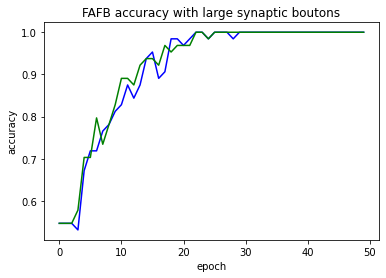

 25%|██▌       | 50/200 [12:12<36:36, 14.64s/it]


KeyboardInterrupt: ignored

In [ ]:
#Train and save a resnet 18 model
save_file_prefix = '/content/drive/MyDrive/Pytorch test/2021_08_15_large_boutons' # Change this to something in your google drive so it saves

model_to_test = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_to_test.fc.in_features
# reset final fully connected layer, number of classes = 6, for each neurotransmitter
num_classes = 2
model_to_test.fc = nn.Linear(num_ftrs, num_classes)
model_to_test.to(DEVICE)
optimizer = torch.optim.Adam(model_to_test.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

pretrained_accs = []
training_accuracy = []
for epoch in tqdm.tqdm(range(200)):
  # Train loop
  for batch in dataloader:
    images, labels = batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    output = model_to_test(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()
    

  # Eval loop
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = 0
    for batch in validation_dataloader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = model_to_test(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total += len(predictions)
      total_correct += num_correct
      
    pretrained_accs.append(total_correct / total)
  #Calculate the training accuracy, too
  with torch.no_grad():
    loss_sum = 0
    total_correct = 0
    total = 0
    for batch in dataloader:
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      output = model_to_test(images)
      loss = loss_fn(output, labels)
      loss_sum += loss.item()

      predictions = torch.argmax(output, dim=1)

      num_correct = torch.sum(predictions == labels)
      total += len(predictions)
      total_correct += num_correct
      
    training_accuracy.append(total_correct / total)
    # Plot accuracy
    plt.plot(pretrained_accs, 'b')
    plt.plot(training_accuracy, 'g')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('FAFB accuracy with large synaptic boutons')
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
    #Save while this runs
    if epoch % 50 == 0 or epoch ==1:
      save_file_path = save_file_prefix + str(epoch)
      torch.save(model_to_test, save_file_path)
  plt.close()